<a href="https://colab.research.google.com/github/amber3536/Wildfire_Prediction/blob/main/Resunet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Definition of ResUNet architecture"""
# Taken from https://github.com/nikhilroxtomar/Deep-Residual-Unet/blob/master/Deep%20Residual%20UNet.ipynb

from tensorflow import keras

def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

def get_model(input_shape):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((input_shape[0], input_shape[1], input_shape[2]))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

from keras import backend as K

# Focal Tversky_loss
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))

# Dice Loss
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Keras
ALPHA = 0.8
GAMMA = 2

def focal_loss(targets, inputs, alpha=ALPHA, gamma=GAMMA):

    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)

def get_loss_function(loss_function_name):
    if loss_function_name == "focal_tversky_loss":
        loss_function = focal_tversky_loss
    elif loss_function_name == "dice_coef_loss":
        loss_function = dice_coef_loss
    elif loss_function_name == "dice_coef_binary_loss":
        loss_function = dice_coef_binary_loss
    elif loss_function_name == "focal_loss":
        loss_function = focal_loss
    elif loss_function_name == "sparse_categorical_crossentropy":
        loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    else:
        loss_function = loss_function_name # for keras implemented losses like "categorical_crossentropy"

    return loss_function

2023-12-07 20:15:55.976902: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 20:15:56.019891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 20:15:56.019925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 20:15:56.021087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 20:15:56.029721: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
# import model_satunet
import glob
import os
import sys


# Get loss function
loss_function = get_loss_function('dice_coef_loss')

# Define model architecture
model = get_model([64,64,10])

callbacks = list()

# Define learning rate schedule callback
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001, decay_steps=15, decay_rate=0.96, staircase=True
    )

# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

2023-12-07 20:15:58.137806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22277 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c7:00.0, compute capability: 8.9
2023-12-07 20:15:59.223002: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [3]:
#from google.colab import drive
#drive.mount('drive')

In [4]:
man_length = 21550

In [5]:
import csv
import gzip
import numpy as np

In [6]:
# Number of images and labels in your dataset
num_examples = 21550
#num_examples = 20

# Output file name
#tfrecord_file = 'data.tfrecords'
tfrecord_file = 'data2.tfrecords'

In [7]:
def _parse_function(proto):

    keys_to_features = {
        'feature1': tf.io.VarLenFeature(tf.float32),
        'feature2': tf.io.VarLenFeature(tf.float32),
        'feature3': tf.io.VarLenFeature(tf.float32),
        'feature4': tf.io.VarLenFeature(tf.float32),
        'feature5': tf.io.VarLenFeature(tf.float32),
        'feature6': tf.io.VarLenFeature(tf.float32),
        'feature7': tf.io.VarLenFeature(tf.float32),
        'feature8': tf.io.VarLenFeature(tf.float32),
        'feature9': tf.io.VarLenFeature(tf.float32),
        'feature10': tf.io.VarLenFeature(tf.float32),
        'label': tf.io.VarLenFeature(tf.float32)
    }

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)

    feature_list = []
    for i in range(1, 11):
        #tf.print(f"feature {i}, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'feature{i}']))}")
        feature = tf.zeros([64, 64], tf.float32)
        tensor = tf.sparse.to_dense(parsed_features[f'feature{i}'])
        tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
        if tf.shape(tensor) == [4096]:
            feature = tf.reshape(tensor, [64, 64])
        feature_list.append(feature)

    combined_features = tf.stack(feature_list, axis=-1)
    label = tf.zeros([64, 64], tf.float32)
    #tf.print(f"label, shape : {tf.shape(tf.sparse.to_dense(parsed_features[f'label']))}")
    label = tf.zeros([64, 64], tf.float32)
    tensor = tf.sparse.to_dense(parsed_features[f'label'])
    #tensor = tf.where(tf.math.is_nan(tensor), tf.zeros_like(tensor), tensor)
    if tf.shape(tensor) == [4096]:
        label = tf.reshape(tensor, [64, 64])
    

    return combined_features, label


In [8]:
def count_records(tfrecord_file):
    count = 0
    for _ in tf.data.TFRecordDataset(tfrecord_file):
        count += 1
    return count

In [9]:
count_records(tfrecord_file)

21550

In [10]:
dataset = tf.data.TFRecordDataset(tfrecord_file).cache()

dataset = dataset.map(_parse_function)

# dataset = dataset[:20]


In [11]:
from tqdm import tqdm

In [12]:
# for inputs, labels in dataset:
#     print(inputs.shape)

In [13]:
dataset = dataset.shuffle(buffer_size=man_length)

In [14]:
train_size = int(0.8 * man_length)
val_size = int(0.2 * man_length)

# Split the dataset
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
eval_dataset = remaining_dataset.take(val_size // 2)
test_dataset = remaining_dataset.skip(val_size // 2)

In [15]:
cnt = 0
for inputs, labels in tqdm(train_dataset):
    cnt += 1
print(cnt)

17240it [00:07, 2221.70it/s]

17240


In [16]:
cnt = 0
for inputs, labels in tqdm(test_dataset):
    cnt += 1
print(cnt)

2155it [00:03, 598.50it/s] 

2155


In [17]:
cnt = 0
for inputs, labels in tqdm(eval_dataset):
    cnt += 1
print(cnt)

2155it [00:05, 405.91it/s]

2155


In [18]:
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
eval_dataset = eval_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [19]:
import numpy as np
import scipy.linalg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.compat.v1 import ConfigProto
from skimage.transform import resize

def get_ssim_score(real_image, gen_image):
    real_image = tf.expand_dims(real_image, axis=-1)
    real_image = tf.concat((real_image, real_image, real_image), axis=-1)
    gen_image = tf.expand_dims(gen_image, axis=-1)
    gen_image = tf.concat((gen_image, gen_image, gen_image), axis=-1)

    #print(f"real_image.shape: {real_image.shape}")
    ssim = tf.image.ssim(real_image, gen_image, max_val=1)
    ssim_mean = tf.reduce_mean(ssim)
    return ssim_mean

def scale_images(images, new_shape):
    return np.asarray([resize(image, new_shape, 0) for image in images])

def calculate_fid(model, images1, images2):
    f1 = model.predict([images1], verbose=None)
    f2 = model.predict([images2], verbose=None)
    mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)
    mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
    sum_sq_diff = np.sum((mean1 - mean2)**2)
    cov_mean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
    return fid

def get_fid_score(real_image, gen_image):
    input_shape = (299, 299, 3)
    inception = InceptionV3(include_top=False, pooling='avg', input_shape=input_shape)
    real_image = tf.expand_dims(real_image, axis=-1)
    real_image = tf.concat((real_image, real_image, real_image), axis=-1)
    #real_image = scale_images(real_image, input_shape)
    real_image = tf.image.resize(real_image, [input_shape[0], input_shape[1]], method=tf.image.ResizeMethod.BILINEAR)
    
    gen_image = tf.expand_dims(gen_image, axis=-1)
    gen_image = tf.concat((gen_image, gen_image, gen_image), axis=-1)
    #gen_image = scale_images(gen_image, input_shape)
    gen_image = tf.image.resize(gen_image, [input_shape[0], input_shape[1]], method=tf.image.ResizeMethod.BILINEAR)

    #print(f"real_image.shape: {real_image.shape}")
    #print(f"gen_image.shape: {gen_image.shape}")
    fid = calculate_fid(inception, real_image, gen_image)
    return fid

# Trainset analysis

inputs.shape: (32, 64, 64, 10)
labels.shape: (32, 64, 64)
len(TITLES): 11


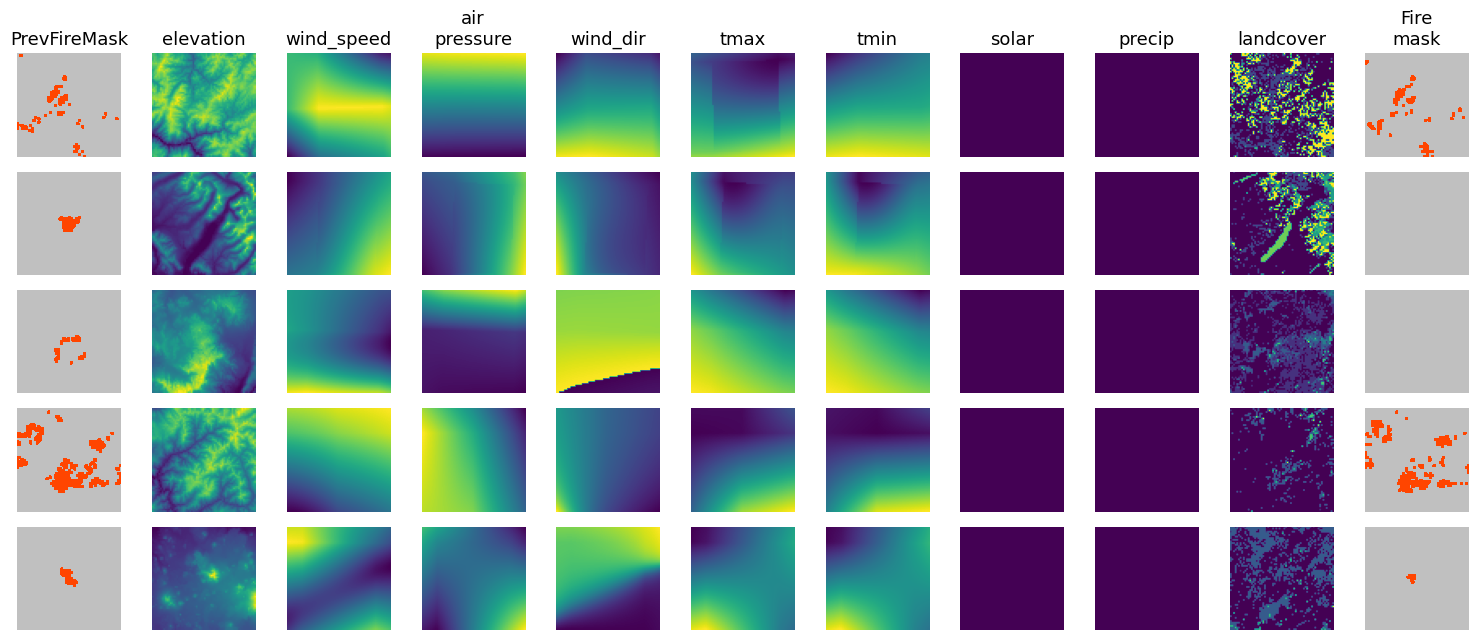

In [20]:
inputs, labels = next(iter(train_dataset))
print(f"inputs.shape: {inputs.shape}")
print(f"labels.shape: {labels.shape}")

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']
print(f"len(TITLES): {len(TITLES)}")


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# len(eval_dataset.take(1))

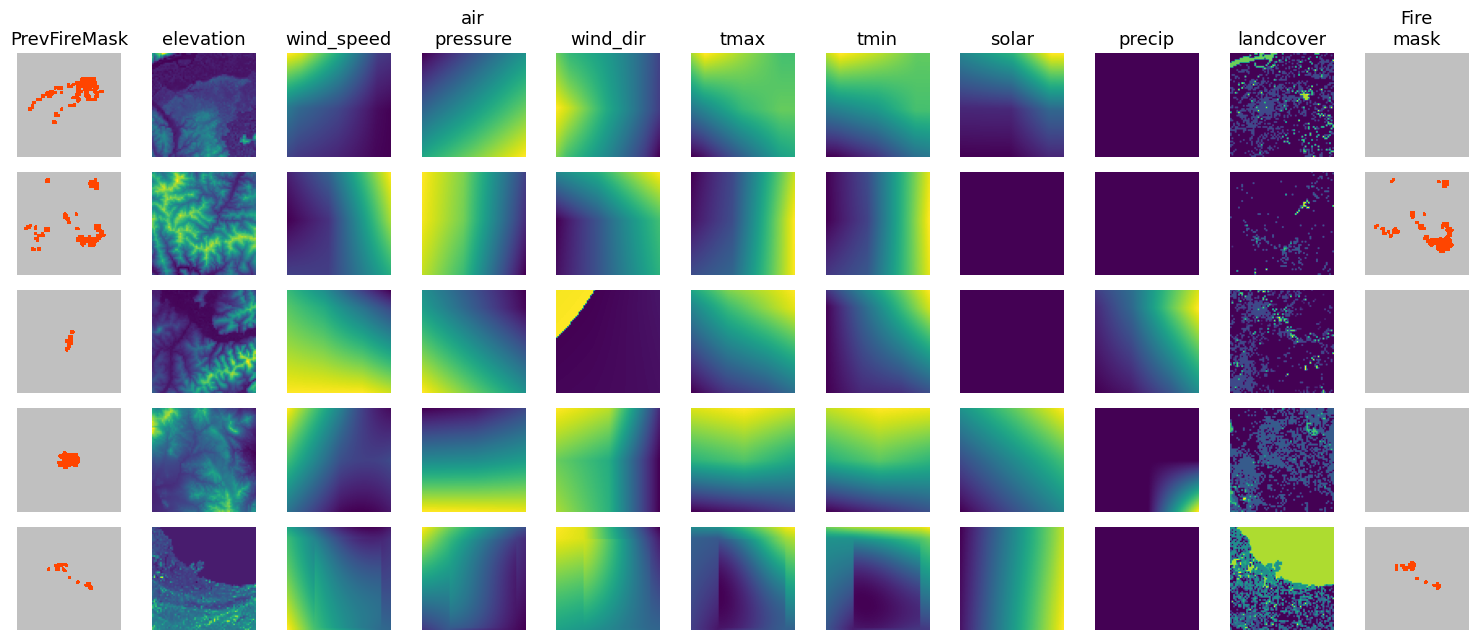

In [22]:
eval_dataset = eval_dataset.shuffle(1000)
inputs, labels = next(iter(eval_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

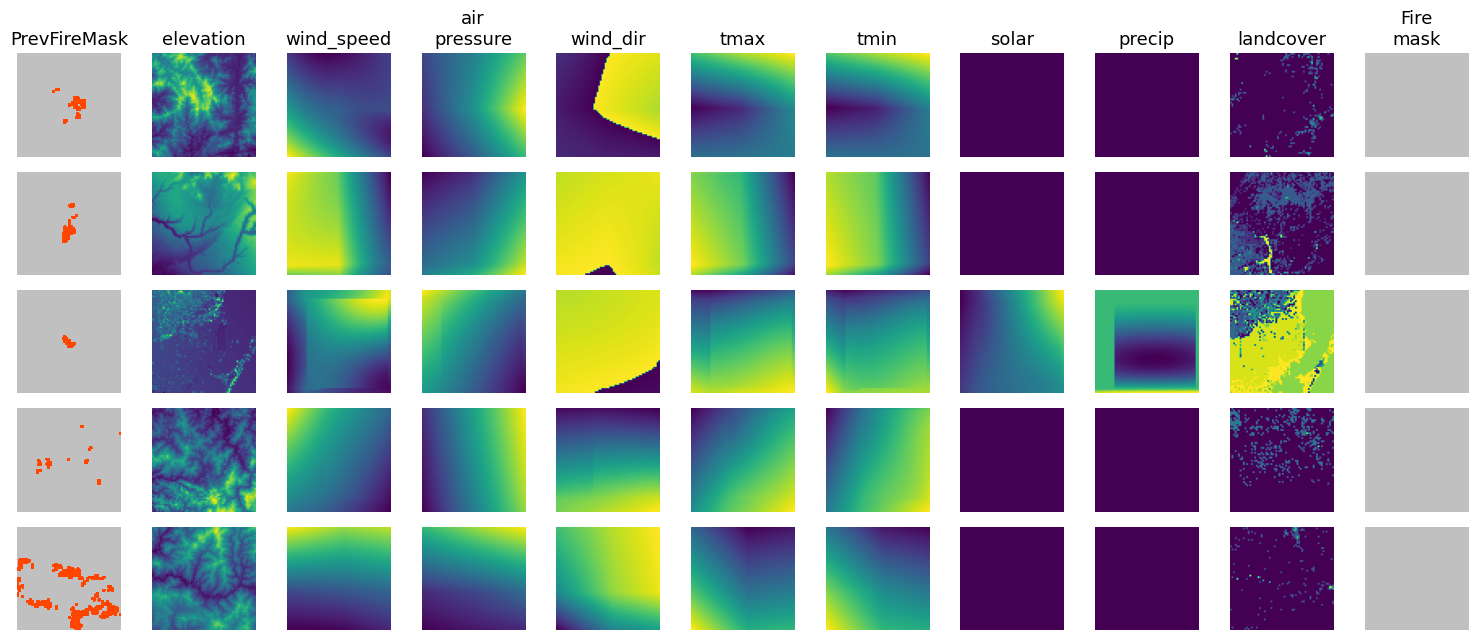

In [23]:
inputs, labels = next(iter(test_dataset))

TITLES = ['PrevFireMask', 'elevation', 'wind_speed', 'air\npressure', 'wind_dir', 'tmax', 'tmin',
                  'solar', 'precip', 'landcover',  'Fire\nmask']


# Number of rows of data samples to plot
n_rows = 5
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
    for j in range(n_features + 1):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(TITLES[j], fontsize=13)
        if j == 0:
            plt.imshow(inputs[i, :, :, 0], cmap=CMAP, norm=NORM)
        if j > 0 and j < n_features:
            plt.imshow(inputs[i, :, :, j], cmap='viridis')
        
        if j == n_features:
            plt.imshow(labels[i, :, :], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Evaluate using sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Get all samples from TFRecords in arrays
first_it = True
cnt = 0
for x, y in test_dataset:
    cnt += 1
    if first_it:
        test_data_inputs = x
        test_data_targets = y
        first_it = False
    else:
        test_data_inputs = np.concatenate((test_data_inputs, x), axis=0)        
        test_data_targets = np.concatenate((test_data_targets, y), axis=0)        
print(f"test inputs num batches = {cnt}")
test_data_inputs = np.asarray(test_data_inputs)
y_true = np.asarray(test_data_targets)
print(f"test_data_targets.shape {test_data_targets.shape}")
print(f"test_data_inputs.shape {test_data_inputs.shape}")

# Flatten results before evaluation
previous_fire_mask_flat = test_data_inputs[:, :, :, 0].flatten()
persistence_mask_flat = previous_fire_mask_flat
y_true_flat = y_true.flatten()

test inputs num batches = 68
test_data_targets.shape (2155, 64, 64)
test_data_inputs.shape (2155, 64, 64, 10)


In [25]:
# # Metrics for baseline
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, persistence_mask_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, persistence_mask_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, persistence_mask_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, persistence_mask_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, persistence_mask_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, persistence_mask_flat)
print(matrix)

Accuracy: 0.983957
score_a (array([0.9967934 , 0.14239609]), array([0.98704664, 0.40382354]), array([0.99189608, 0.21054861]), array([8780117,   46763]))
precision 0.9839568454538863
Recall: 0.983957
F1 score: 0.983957
[[8666385  113732]
 [  27879   18884]]


# Training

In [26]:
# Compile and train model

model.compile(
    optimizer=optimizer,
    loss=loss_function, metrics=[dice_coef,
                                 tf.keras.metrics.AUC(curve="PR"),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.Recall()
                                ]
    )

#model.fit(train_dataset, epochs=5)
history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


2023-12-07 20:17:17.113431: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-07 20:17:17.267771: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-07 20:17:20.290969: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0b8b706280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 20:17:20.290995: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-07 20:17:20.296285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702009040.416983 3946694 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


539/539 [==============================] - 62s 70ms/step - loss: 0.7900 - dice_coef: 0.2100 - auc: 0.0624 - precision: 0.0815 - recall: 0.4008 - val_loss: 0.7482 - val_dice_coef: 0.2528 - val_auc: 0.1149 - val_precision: 0.2002 - val_recall: 0.3653
Epoch 2/100
539/539 [==============================] - 36s 54ms/step - loss: 0.7342 - dice_coef: 0.2658 - auc: 0.1238 - precision: 0.2230 - recall: 0.3578 - val_loss: 0.7221 - val_dice_coef: 0.2794 - val_auc: 0.1375 - val_precision: 0.2504 - val_recall: 0.3486
Epoch 3/100
539/539 [==============================] - 37s 57ms/step - loss: 0.7232 - dice_coef: 0.2768 - auc: 0.1336 - precision: 0.2466 - recall: 0.3453 - val_loss: 0.7232 - val_dice_coef: 0.2750 - val_auc: 0.1391 - val_precision: 0.2495 - val_recall: 0.3593
Epoch 4/100
539/539 [==============================] - 38s 57ms/step - loss: 0.7196 - dice_coef: 0.2804 - auc: 0.1374 - precision: 0.2501 - recall: 0.3522 - val_loss: 0.7202 - val_dice_coef: 0.2781 - val_auc: 0.1364 - val_precisi

# Evaluation

In [27]:
# Predict
y_pred=list()
for sample in tqdm(test_data_inputs):
    sample_exp = np.expand_dims(sample, axis=0)
    
    pred = model.predict(sample_exp, verbose = 0)
    
    y_pred.append(pred)
    
masks = np.round(y_pred)

# Flatten results before evaluation
y_pred_mask_flat = np.expand_dims(np.array(y_pred).squeeze(), axis=-1).flatten()
masks_flat = masks.flatten()

# Metrics for predicitions
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true_flat, masks_flat)
print('Accuracy: %f' % accuracy)
score_a = score(y_true_flat, masks_flat)
print("score_a", score_a)
# precision tp / (tp + fp)
precision = precision_score(y_true_flat, masks_flat, average='micro')
print("precision", precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true_flat, masks_flat, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true_flat, masks_flat, average='micro')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(y_true_flat, masks_flat)
print(matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2155/2155 [02:19<00:00, 15.45it/s]


Accuracy: 0.990631
score_a (array([0.99660994, 0.24362998]), array([0.9939617 , 0.36518187]), array([0.99528406, 0.29227175]), array([8780117,   46763]))
precision 0.990630551225348
Recall: 0.990631
F1 score: 0.990631
[[8727100   53017]
 [  29686   17077]]


In [28]:
ssim_scores_input_labels = []
ssim_scores_input_predictions = []
ssim_scores_labels_predictions = []
for inputs, labels in tqdm(test_dataset):
    pred = tf.squeeze(model.predict(inputs, verbose = 0))
    ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], labels[:, :, :])))
    ssim_scores_input_labels.append(ssim_score)
    ssim_score = float(tf.reduce_mean(get_ssim_score(inputs[:, :, :, 0], pred)))
    ssim_scores_input_predictions.append(ssim_score)
    ssim_score = float(tf.reduce_mean(get_ssim_score(labels[:, :, :], pred)))
    ssim_scores_labels_predictions.append(ssim_score)
    

print(f"final_ssim_scores_input_labels.append({np.mean(ssim_scores_input_labels)})")
print(f"final_ssim_scores_input_predictions.append({np.mean(ssim_scores_input_predictions)})")
print(f"final_ssim_scores_labels_predictions.append({np.mean(ssim_scores_labels_predictions)})")

68it [00:12,  5.23it/s]

final_ssim_scores_input_labels.append(0.8433738605064505)
final_ssim_scores_input_predictions.append(0.898263568387312)
final_ssim_scores_labels_predictions.append(0.9040546522420996)


In [29]:
np.where(y_true_flat < 1.)[0].shape

(8780117,)

In [30]:
np.where(y_true_flat > 0.)[0].shape

(46763,)

In [31]:
y_true.shape

(2155, 64, 64)

In [32]:
tf.unique(persistence_mask_flat)

Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(8826880,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

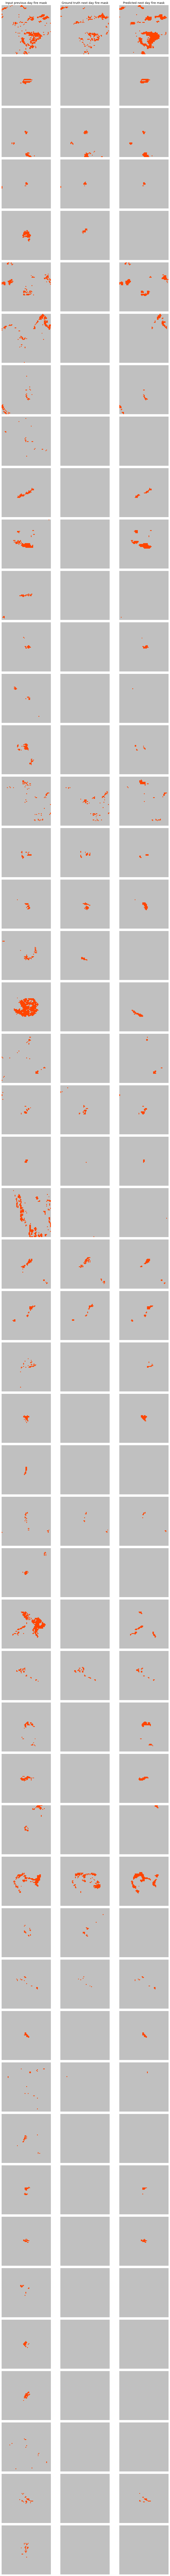

In [33]:
# Output visualisation
output_titles = ["Input previous day fire mask", "Ground truth next day fire mask", "Predicted next day fire mask" ]

n_rows = 50
n_features = len(output_titles)

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0., 1.]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,160.5))

for i in range(n_rows):
    for j in range(n_features):
        plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
        if i == 0:
            plt.title(output_titles[j], fontsize=13)
        if j == 0:
            plt.imshow(test_data_inputs[i, :, :, 0], cmap=CMAP, norm=NORM) 
        if j == 1:
            plt.imshow(y_true[i, :, :], cmap=CMAP, norm=NORM)
        if j == 2:
            plt.imshow(masks.squeeze(axis=1)[i, :, :, 0], cmap=CMAP, norm=NORM) 
        plt.axis('off')
plt.tight_layout()

In [6]:
final_ssim_scores_input_labels = []
final_ssim_scores_input_predictions = []
final_ssim_scores_labels_predictions = []

In [7]:
final_ssim_scores_input_labels.append(0.8416798596873003)
final_ssim_scores_input_predictions.append(0.8955558143994388)
final_ssim_scores_labels_predictions.append(0.903132347499623)

final_ssim_scores_input_labels.append(0.8374357828322578)
final_ssim_scores_input_predictions.append(0.8977179220494103)
final_ssim_scores_labels_predictions.append(0.898909758995561)

final_ssim_scores_input_labels.append(0.8433738605064505)
final_ssim_scores_input_predictions.append(0.898263568387312)
final_ssim_scores_labels_predictions.append(0.9040546522420996)

In [8]:
import numpy as np
print(f"final_ssim_scores_input_labels: {np.mean(final_ssim_scores_input_labels):.5f} +- {np.std(final_ssim_scores_input_labels):.5f}")
print(f"final_ssim_scores_input_predictions: {np.mean(final_ssim_scores_input_predictions):.5f} +- {np.std(final_ssim_scores_input_predictions):.5f}")
print(f"final_ssim_scores_labels_predictions: {np.mean(final_ssim_scores_labels_predictions):.5f} +- {np.std(final_ssim_scores_labels_predictions):.5f}")

final_ssim_scores_input_labels: 0.84083 +- 0.00250
final_ssim_scores_input_predictions: 0.89718 +- 0.00117
final_ssim_scores_labels_predictions: 0.90203 +- 0.00224


In [36]:
# f1 score

baseline_mean = np.mean([0.983005, 0.983800, 0.983907])
baseline_std = np.std([0.983005, 0.983800, 0.983907])

resunet_mean = np.mean([0.990329, 0.990496, 0.990242])
resunet_std = np.std([0.990329, 0.990496, 0.990242])

print(f"f1 baseline: {baseline_mean:.5f}+={baseline_std:.5f} resunet: {resunet_mean:.5f}+={resunet_std:.5f}")


# precision

baseline_mean = np.mean([0.9830046403712297, 0.9837999383700696, 0.983907337587007])
baseline_std = np.std([0.9830046403712297, 0.9837999383700696, 0.983907337587007])

resunet_mean = np.mean([0.9903286325406032, 0.9904963022041763, 0.9902424186122389])
resunet_std = np.std([0.9903286325406032, 0.9904963022041763, 0.9902424186122389])

print(f"precision baseline: {baseline_mean:.5f}+={baseline_std:.5f} resunet: {resunet_mean:.5f}+={resunet_std:.5f}")


# recall

baseline_mean = np.mean([ 0.983005, 0.983800, 0.983907])
baseline_std = np.std([ 0.983005, 0.983800, 0.983907])

resunet_mean = np.mean([0.990329, 0.990496, 0.990242])
resunet_std = np.std([0.990329, 0.990496, 0.990242])

print(f"recall baseline: {baseline_mean:.5f}+={baseline_std:.5f} resunet: {resunet_mean:.5f}+={resunet_std:.5f}")


# accuracy

baseline_mean = np.mean([0.983005, 0.983800, 0.983907])
baseline_std = np.std([0.983005, 0.983800, 0.983907])

resunet_mean = np.mean([0.990329,  0.990496, 0.990242])
resunet_std = np.std([0.990329,  0.990496, 0.990242])

print(f"accuracy baseline: {baseline_mean:.5f}+={baseline_std:.5f} resunet: {resunet_mean:.5f}+={resunet_std:.5f}")

f1 baseline: 0.98357+=0.00040 resunet: 0.99036+=0.00011
precision baseline: 0.98357+=0.00040 resunet: 0.99036+=0.00011
recall baseline: 0.98357+=0.00040 resunet: 0.99036+=0.00011
accuracy baseline: 0.98357+=0.00040 resunet: 0.99036+=0.00011
